In [1]:
import numpy as np
import mne
from mne.datasets import sample
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import scipy.signal as sl
from typing import Optional
import scipy as sp
import sys
from nilearn import plotting
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.convtools import conviter
from deepmeg.models.interpretable import SPIRIT
from deepmeg.data.datasets import EpochsDataset, read_epochs_dataset
from torch.utils.data import DataLoader
from deepmeg.preprocessing.transforms import zscore
import torch
from collections import defaultdict
import torchmetrics
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg, PrintingCallback
from deepmeg.interpreters import SPIRITInterpreter
import random


In [2]:
def generate_activations(
    event_names, roi_labels, n_rois=1
):
    start = 0
    random.shuffle(roi_labels)
    activations = dict()

    for event in event_names:
        n_rois_sel = int(np.random.randint(1, n_rois+1))
        sel_rois = roi_labels[start:start+n_rois_sel]
        activations[event] = [(sel_roi.name, int(np.random.randint(10, 100))) for sel_roi in sel_rois]
        start += n_rois_sel

        if start >= len(roi_labels):
            break

    return activations


def plot_roi(roi_labels, subject, subjects_dir, colors=None, marker_sizes=None):
    coords = list()
    for roi_label in roi_labels:
        if roi_label.name[-2:] == 'lh':
            hemi = 0
        elif roi_label.name[-2:] == 'rh':
            hemi = 1
        else: raise ValueError(f'Hemisphere undefined: {roi_label.name}')

        coords.append(
            mne.vertex_to_mni(
                roi_label.center_of_mass(
                    subject,
                    subjects_dir=subjects_dir
                ),
                hemi,
                subject,
                subjects_dir=subjects_dir
            )
        )
    if isinstance(colors, str):
        colors = [colors for _ in coords]
    view = plotting.view_markers(
        coords, colors,
        marker_size=marker_sizes
    )
    return view


def data_fun(times, latency, duration, rng=None, f = 15):
    """Function to generate source time courses for evoked responses,
    parametrized by latency and duration."""
    if not rng:
        rng = np.random.RandomState(7)
    sigma = 0.375 * duration
    sinusoid = np.sin(2 * np.pi * f * (times - latency))
    gf = np.exp(- (times - latency - (sigma / 4.) * rng.rand(1)) ** 2 /
                (2 * (sigma ** 2)))
    return 1e-9 * sinusoid * gf


# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [3]:
from collections import namedtuple

EventConfig = namedtuple('EventConfig', 'start duration id')


def create_events(*configs: EventConfig, duration, sfreq):
    n_points = int(duration*sfreq)
    all_events = list()
    for config in configs:
        currect_timepoint = int(config.start*sfreq)
        events = list()
        while currect_timepoint < n_points:
            events.append([currect_timepoint, 0, config.id])
            currect_timepoint += int(config.duration*sfreq)
        all_events += events
    all_events = np.array(all_events)
    return all_events[np.argsort(all_events[:, 0])]


In [4]:
data_path = sample.data_path()
subjects_dir = data_path / 'subjects'
subject = 'sample'
meg_path = data_path / 'MEG' / subject
fname_info = meg_path / 'sample_audvis_raw.fif'
info_orig = mne.io.read_info(fname_info)
tstep = 1 / info_orig['sfreq']
fwd_fname = meg_path / 'sample_audvis-meg-eeg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fwd_fname)
src = fwd['src']
fname_event = meg_path / 'sample_audvis_raw-eve.fif'
fname_cov = meg_path / 'sample_audvis-cov.fif'

events = mne.read_events(fname_event)

# events = create_events(
#     EventConfig(10.6, 1.25, 1),
#     EventConfig(11.2, 1.5, 2),
#     EventConfig(12.0, 1., 3),
#     EventConfig(11.8, 1., 4),
#     EventConfig(11.2, 1.25, 4),
#     EventConfig(10.4, 1.5, 4),
#     duration=200,
#     sfreq=info_orig['sfreq']
# )

noise_cov = mne.read_cov(fname_cov)

event_id = {'e1': 1, 'e2': 2, 'e3': 3,
            'e4': 4, 'e5': 5, 'e6': 32}

all_labels = mne.read_labels_from_annot('sample', parc='aparc.a2009s', subjects_dir=subjects_dir)
label_by_name = {label.name: label for label in all_labels}


In [5]:
label_by_name.keys()

dict_keys(['G_Ins_lg_and_S_cent_ins-lh', 'G_Ins_lg_and_S_cent_ins-rh', 'G_and_S_cingul-Ant-lh', 'G_and_S_cingul-Ant-rh', 'G_and_S_cingul-Mid-Ant-lh', 'G_and_S_cingul-Mid-Ant-rh', 'G_and_S_cingul-Mid-Post-lh', 'G_and_S_cingul-Mid-Post-rh', 'G_and_S_frontomargin-lh', 'G_and_S_frontomargin-rh', 'G_and_S_occipital_inf-lh', 'G_and_S_occipital_inf-rh', 'G_and_S_paracentral-lh', 'G_and_S_paracentral-rh', 'G_and_S_subcentral-lh', 'G_and_S_subcentral-rh', 'G_and_S_transv_frontopol-lh', 'G_and_S_transv_frontopol-rh', 'G_cingul-Post-dorsal-lh', 'G_cingul-Post-dorsal-rh', 'G_cingul-Post-ventral-lh', 'G_cingul-Post-ventral-rh', 'G_cuneus-lh', 'G_cuneus-rh', 'G_front_inf-Opercular-lh', 'G_front_inf-Opercular-rh', 'G_front_inf-Orbital-lh', 'G_front_inf-Orbital-rh', 'G_front_inf-Triangul-lh', 'G_front_inf-Triangul-rh', 'G_front_middle-lh', 'G_front_middle-rh', 'G_front_sup-lh', 'G_front_sup-rh', 'G_insular_short-lh', 'G_insular_short-rh', 'G_oc-temp_lat-fusifor-lh', 'G_oc-temp_lat-fusifor-rh', 'G_oc-t

In [6]:
activations = {
    'e1': [
        ('S_interm_prim-Jensen-rh', 41),
        ('S_intrapariet_and_P_trans-rh', 17)
        # ('S_oc_middle_and_Lunatus-rh', 53),
    ],
    'e2': [
        ('S_oc-temp_lat-rh', 37),
        ('S_oc-temp_med_and_Lingual-rh', 19),
    ],
    'e3': [
        ('S_circular_insula_inf-rh', 78),
        ('S_collat_transv_post-rh', 28)
        # ('G_orbital-rh', 70)
    ],
}

In [7]:
new_activations = generate_activations(
    [
        'e4',
        'e5', 'e6'
    ], all_labels, 8
)

In [8]:
# all_activations = dict(**activations, **new_activations)
all_activations = activations

In [9]:

labels = list()
marker_sizes = list()
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet']
all_colors = list()
for color, (event_name, activation) in zip(colors, all_activations.items()):
    for a in activation:
        labels.append(label_by_name[a[0]])
        marker_sizes.append(a[1])
        all_colors.append(color)

plot_roi(labels, 'sample', subjects_dir, all_colors, marker_sizes)

In [10]:
annot = 'aparc.a2009s'
label_names = sorted(set(activation[0]
                         for activation_list in all_activations.values()
                         for activation in activation_list))
region_names = list(all_activations.keys())

In [11]:
times = np.arange(600, dtype=np.float64) / info_orig['sfreq']
rng = np.random.RandomState(7)
source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)

# durations = [0.05, 0.08, 0.1]
# latencies = [0.1, 0.5, 0.8]
# freqs = [10., 20., 30.]

cfg_data = dict()

for region_id, region_name in enumerate(region_names, 1):
    events_tmp = events[np.where(events[:, 2] == region_id)[0], :]
    for i in range(len(all_activations[region_name])):
        label_name = all_activations[region_name][i][0]
        label_tmp = mne.read_labels_from_annot(subject, annot,
                                               subjects_dir=subjects_dir,
                                               regexp=label_name,
                                               verbose=False)
        label_tmp = label_tmp[0]
        amplitude_tmp = all_activations[region_name][i][1]

        if region_name in activations.keys():
            duration = np.random.uniform(0.01, 0.1)
            # duration = durations[region_id-1]
            latency_tmp = np.random.uniform(0.1, 0.6)
            # latency_tmp = latencies[region_id-1]
            f = np.random.uniform(8., 30.)
        else:
            duration = np.random.uniform(0.01, 0.5)
            latency_tmp = np.random.uniform(0.1, 1.6)
            f = np.random.uniform(8., 30.)
        if region_name not in cfg_data:
            cfg_data[region_name] = dict()
        cfg_data[region_name][label_name] = dict(duration=duration, latency=latency_tmp, frequency=f)
        # f = freqs[region_id-1]
        wf_tmp = data_fun(times, latency_tmp, duration, f=f)
        source_simulator.add_data(label_tmp,
                                  amplitude_tmp * wf_tmp,
                                  events_tmp)

# To obtain a SourceEstimate object, we need to use `get_stc()` method of
# SourceSimulator class.
stc_data = source_simulator.get_stc()

In [12]:
for event, eventdict in cfg_data.items():
    print(f'{event}:')
    for region, regiondict in eventdict.items():
        print(f'\t{region}:')
        for param, value in regiondict.items():
            print(f'\t\t{param}: {value}')

e1:
	S_interm_prim-Jensen-rh:
		duration: 0.02310541329262268
		latency: 0.5778231438877534
		frequency: 24.73903542149119
	S_intrapariet_and_P_trans-rh:
		duration: 0.014586296899168148
		latency: 0.4474871405990176
		frequency: 26.12888271483044
e2:
	S_oc-temp_lat-rh:
		duration: 0.027998672628649725
		latency: 0.2220705372399759
		frequency: 13.916103647230152
	S_oc-temp_med_and_Lingual-rh:
		duration: 0.06144446231510404
		latency: 0.2767034512611235
		frequency: 12.565964591059718
e3:
	S_circular_insula_inf-rh:
		duration: 0.022977351354776597
		latency: 0.49338362487092857
		frequency: 23.332072577620323
	S_collat_transv_post-rh:
		duration: 0.03625594878335695
		latency: 0.1837900893338986
		frequency: 28.01334303873493


In [13]:
raw_sim = mne.simulation.simulate_raw(info_orig, source_simulator, forward=fwd)
raw_sim.set_eeg_reference(projection=True)

mne.simulation.add_noise(
    raw_sim,
    cov=noise_cov,
    random_state=0
)

<RawArray | 376 x 154680 (257.5 s), ~447.0 MB, data loaded>

In [14]:
epochs = mne.Epochs(raw_sim, events, event_id, tmin=-0.2, tmax=2.,
                    baseline=(None, 0), event_repeated='drop')
epochs.load_data().resample(600).crop(0., None).pick_types(meg='grad')
epochsoi = epochs[['e1', 'e2', 'e3']]
evo = epochsoi.average(by_event_type=True)

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


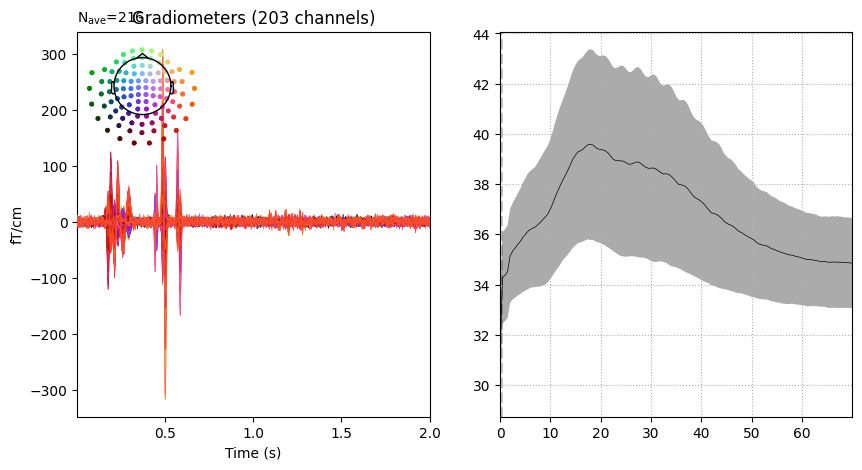

In [15]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
epochsoi.plot_psd(average=True, ax=ax2, fmax=70)
epochsoi.average().plot(axes=ax1)
plt.show()

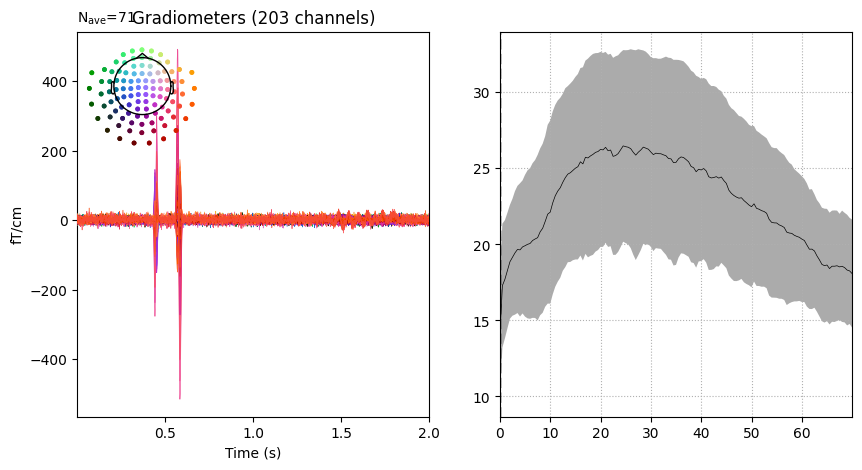

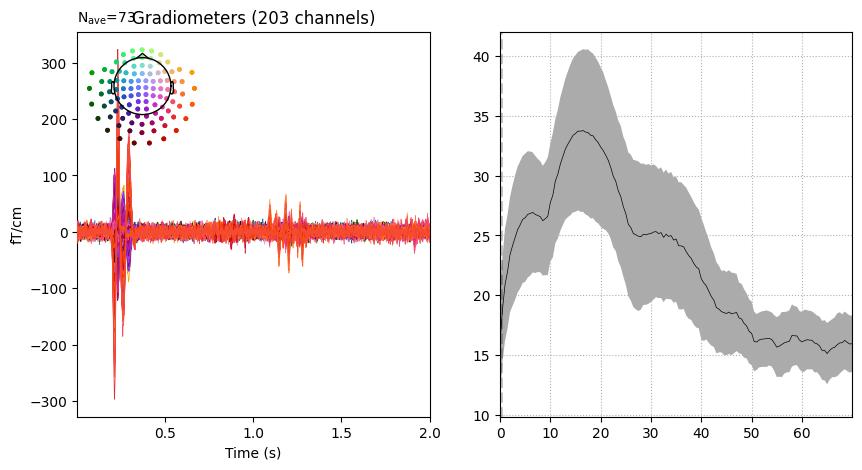

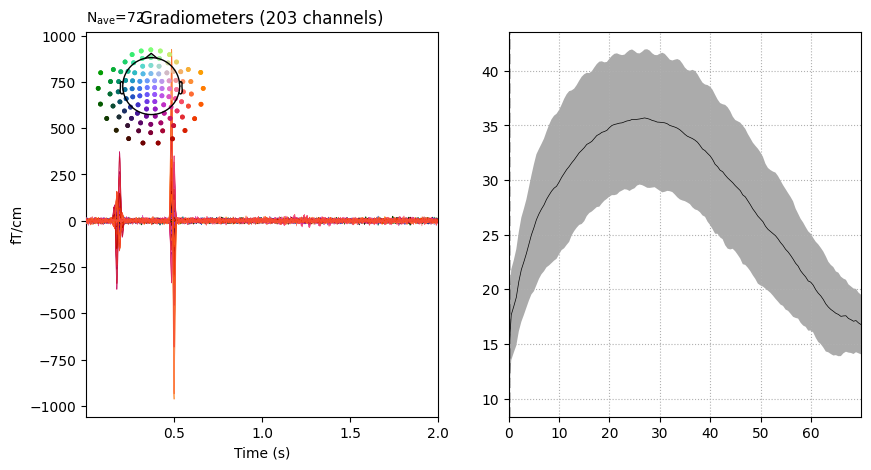

In [16]:
for evoked in evo:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    evoked.plot_psd(average=True, ax=ax2, fmax=70)
    evoked.plot(axes=ax1)
    plt.show()

In [108]:
data = epochsoi.get_data().copy()
labels = epochsoi.events[:, 2]

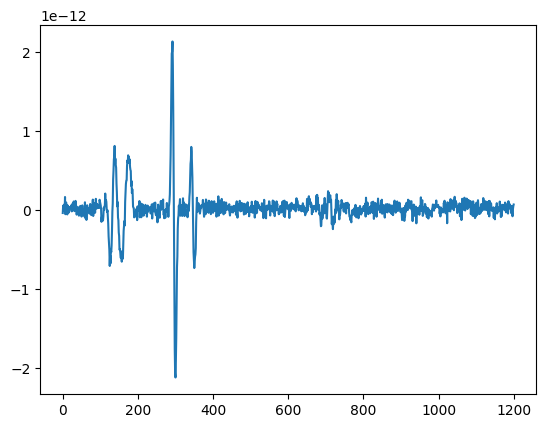

In [109]:
plt.plot(data.mean((0,1)))
plt.show()

In [19]:
data.shape

(216, 203, 1201)

In [43]:
data[:, :, 400:] = 2*5e-10*np.random.random((216, 203, 801)) - 5e-10

In [110]:
data += 2*5e-11*np.random.random((216, 203, 1201)) - 5e-11

In [100]:
data += 2*1e-10*np.random.random((216, 203, 1201)) - 1e-10

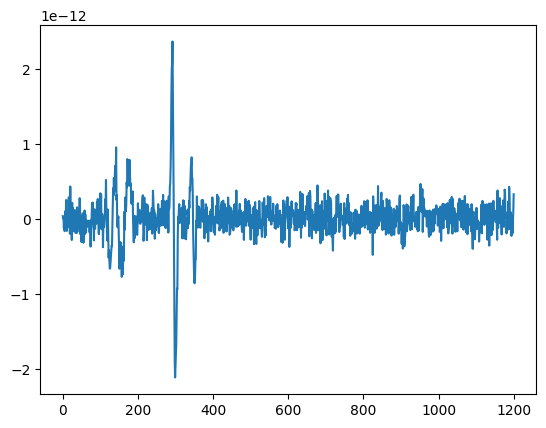

In [111]:
plt.plot(data.mean((0,1)))
plt.show()

In [31]:
from deepmeg.preprocessing.transforms import one_hot_encoder

In [114]:
dataset = EpochsDataset(
    (
        # epochsoi
        data,
        one_hot_encoder(labels)
    ),
    savepath='../simulated',
    transform=zscore
)

In [33]:
dataset.save('../dataset/simulated.pt')

In [53]:
dataset = read_epochs_dataset('../dataset/simulated.pt')

In [115]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [66]:
kwargs = dict(
    n_channels=203,
    n_latent=8,
    # n_times=601,
    n_times=1201,
    filter_size=50,
    window_size=10,
    latent_dim=10,
    pool_factor=10,
    n_outputs=3
)

In [36]:
# from mne.datasets import multimodal
# fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
data_path = sample.data_path()
subjects_dir = data_path / 'subjects'
subject = 'sample'
meg_path = data_path / 'MEG' / subject
fname_raw = meg_path / 'sample_audvis_raw.fif'

info = mne.io.read_raw_fif(fname_raw).resample(600).pick_types(meg='grad').info

In [164]:
from deepmeg.models.interpretable import LFCNN

model = LFCNN(
    n_channels=203, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=1201,
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=3 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7210   |    binary_accuracy_train:  0.5442   |    loss_val:  0.7188   |    binary_accuracy_val:  0.5714
Epoch 1:  loss_train:  0.6995   |    binary_accuracy_train:  0.6268   |    loss_val:  0.7106   |    binary_accuracy_val:  0.5810
Epoch 2:  loss_train:  0.6792   |    binary_accuracy_train:  0.6895   |    loss_val:  0.7033   |    binary_accuracy_val:  0.6476
Epoch 3:  loss_train:  0.6598   |    binary_accuracy_train:  0.7208   |    loss_val:  0.6968   |    binary_accuracy_val:  0.6286
Epoch 4:  loss_train:  0.6413   |    binary_accuracy_train:  0.7350   |    loss_val:  0.6910   |    binary_accuracy_val:  0.6476
Epoch 5:  loss_train:  0.6235   |    binary_accuracy_train:  0.7436   |    loss_val:  0.6860   |    binary_accuracy_val:  0.6476
Epoch 6:  loss_train:  0.6063   |    binary_accuracy_train:  0.7493   |    loss_val:  0.6816   |    binary_accuracy_val:  0.6571
Epoch 7:  loss_train:  0.5896   |    binary_accuracy_train:  0.7436   |    loss_val:  0.6777   | 

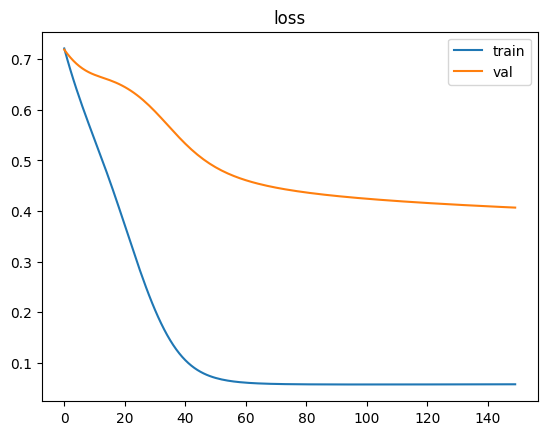

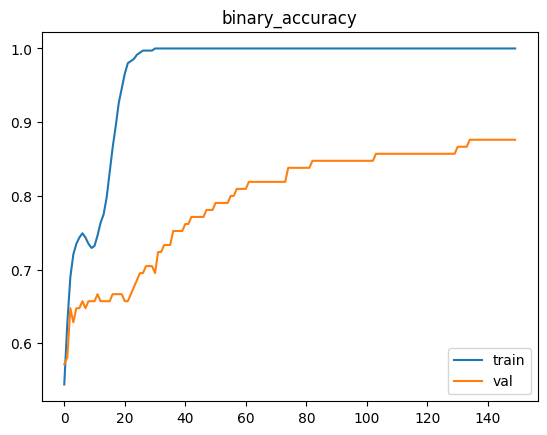

In [165]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [169]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.1410889280113307
train_binary_accuracy: 0.9737373753027483
loss: 0.518583045764403
binary_accuracy: 0.7954545454545454


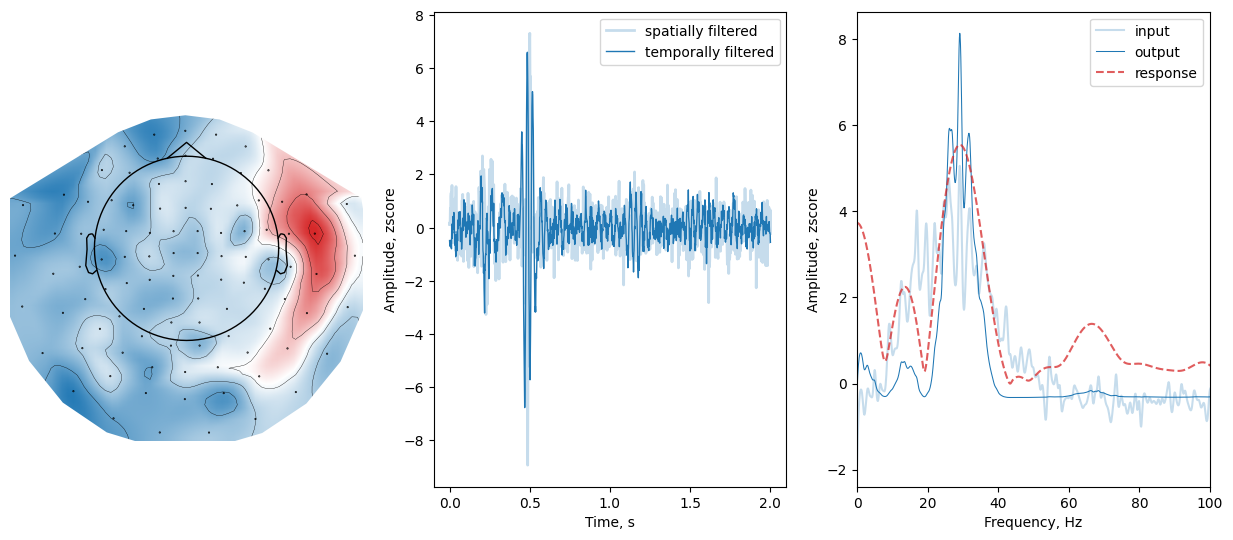

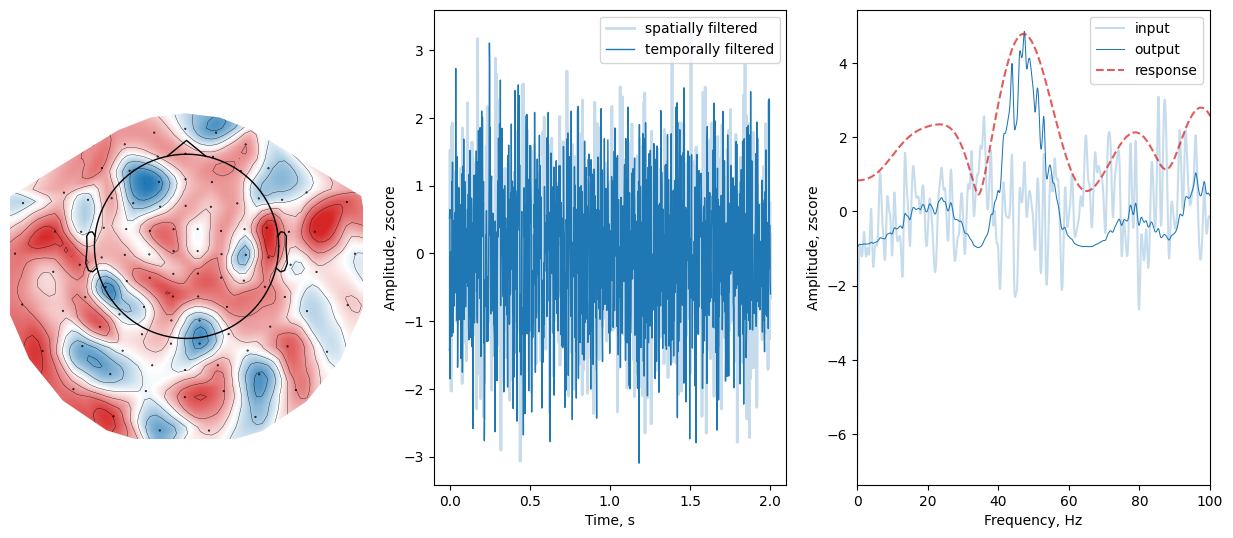

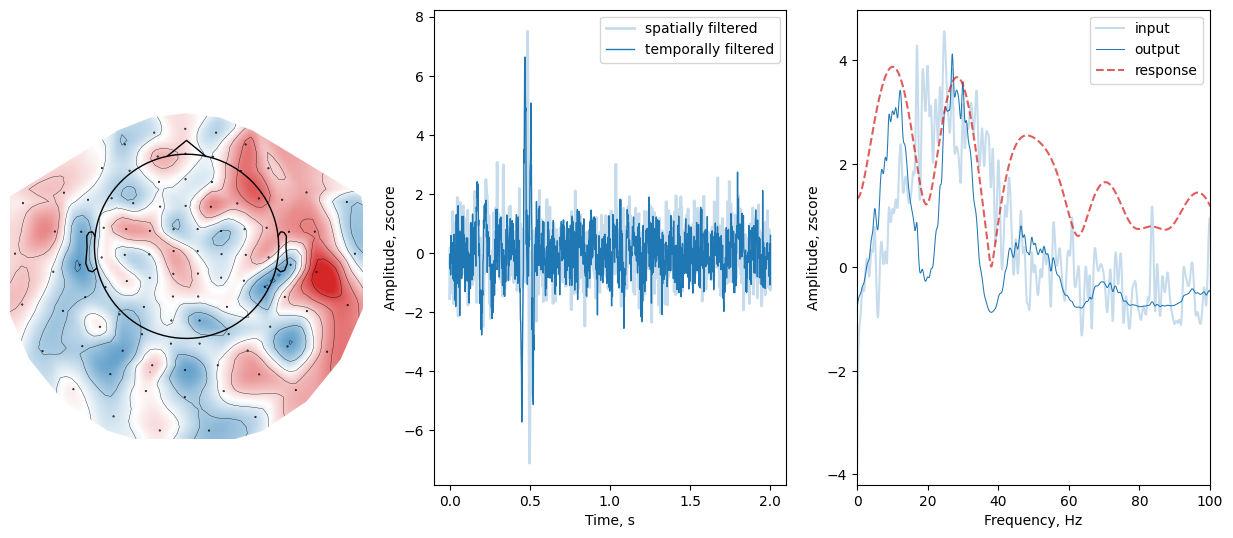

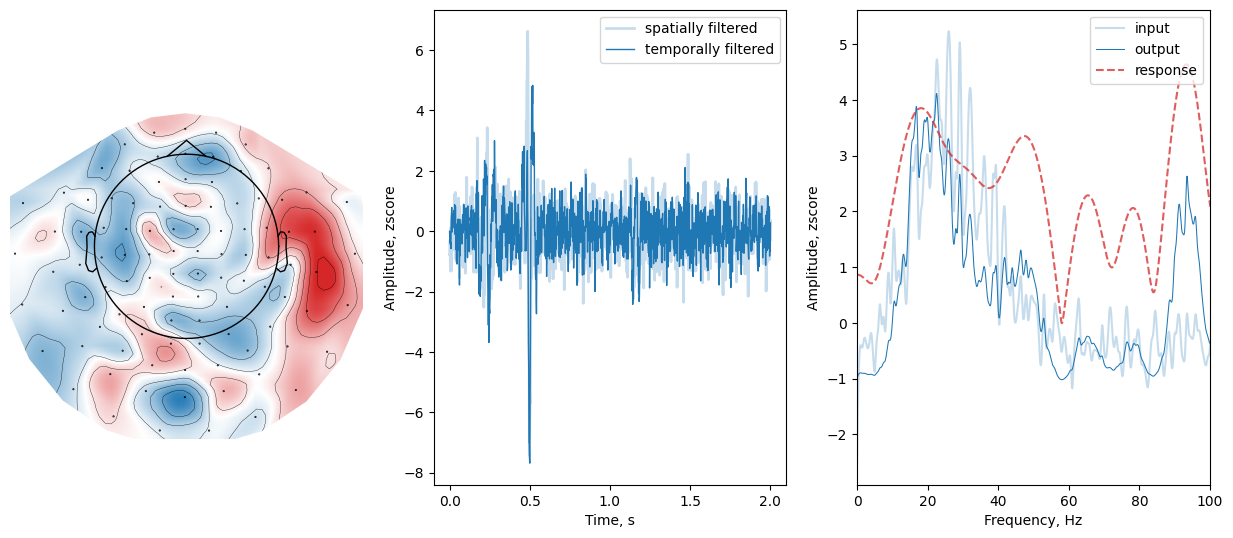

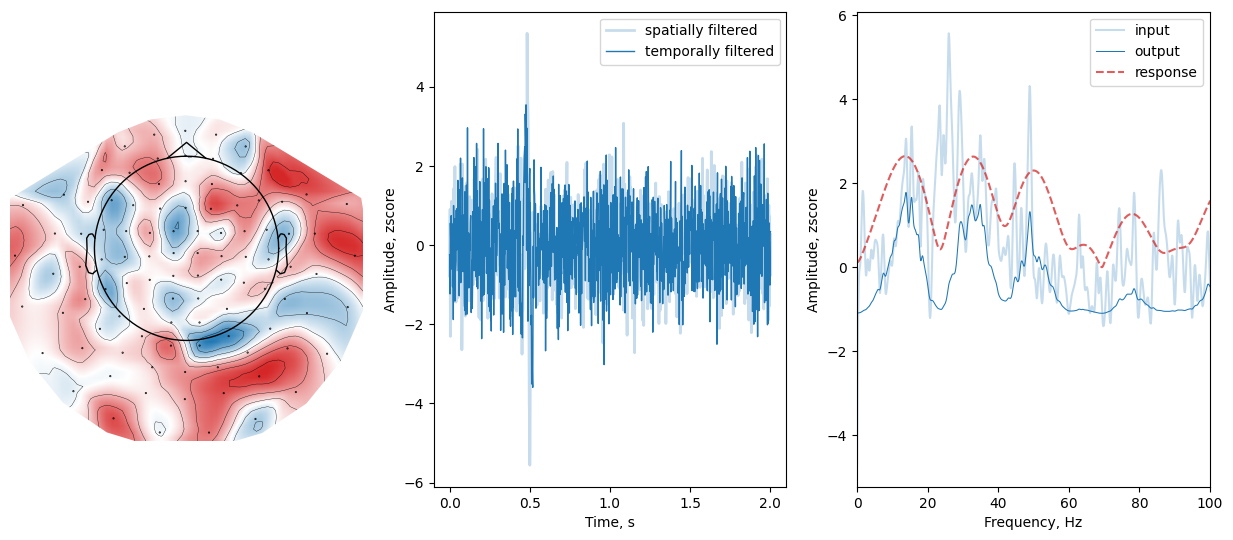

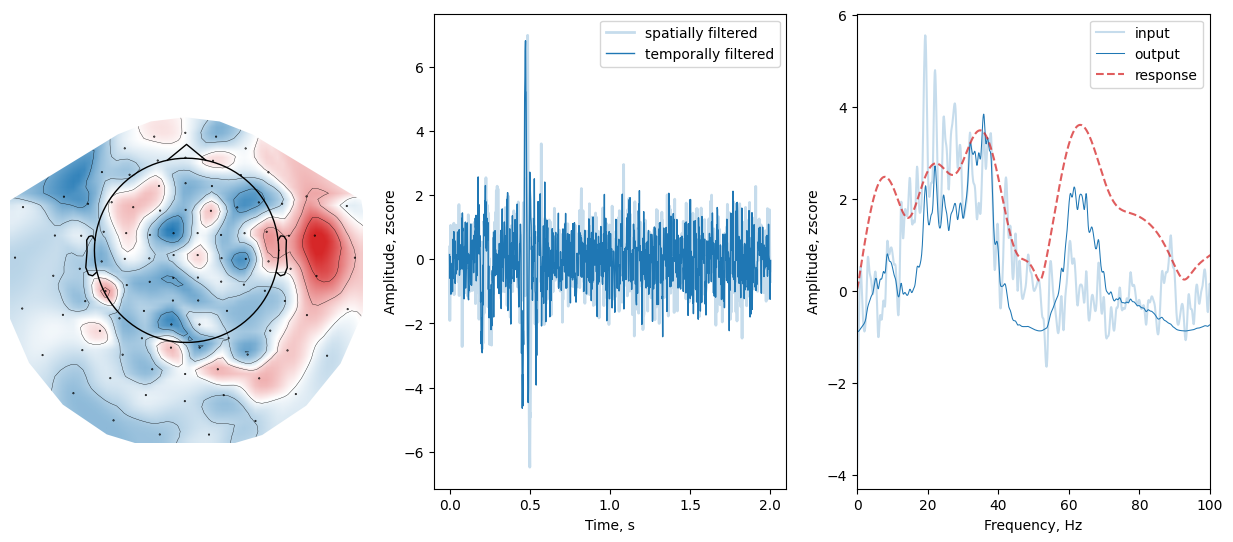

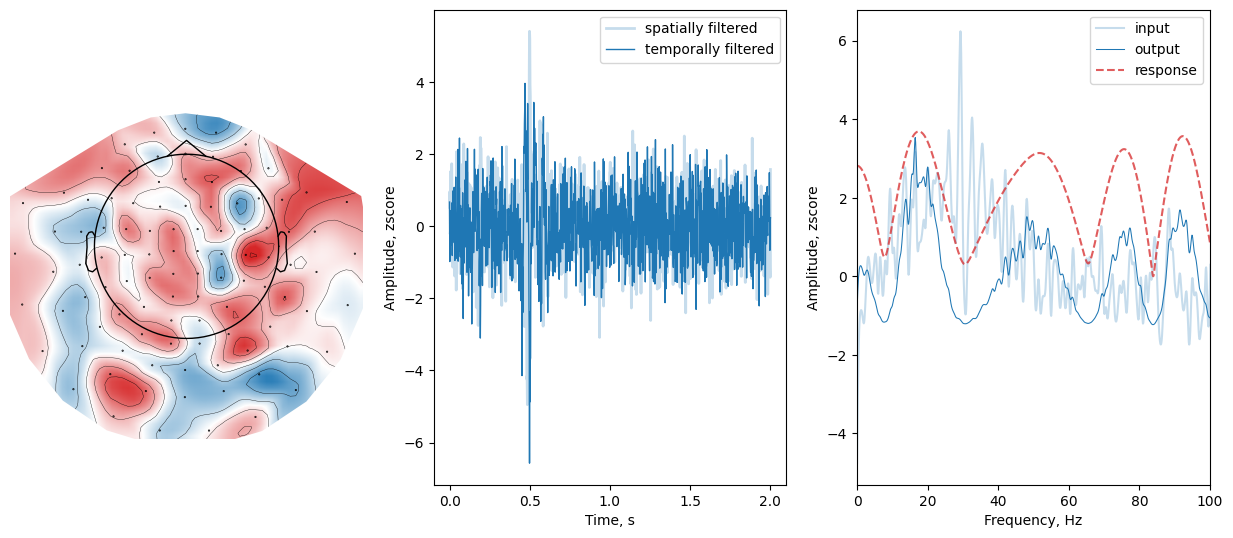

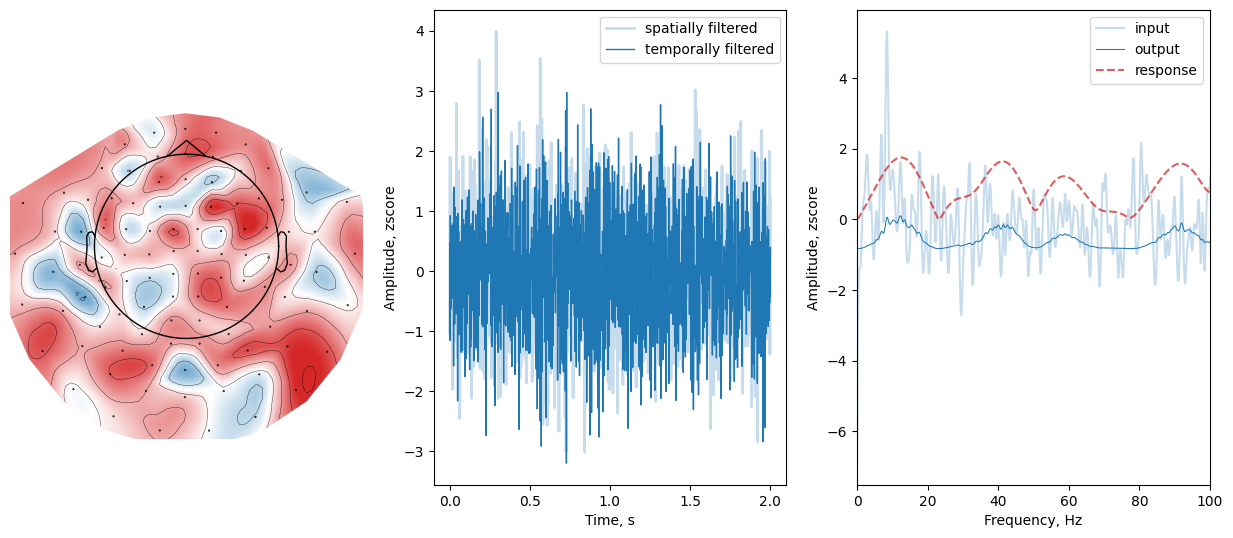

In [170]:
from deepmeg.interpreters import LFCNNInterpreter

interpreter = LFCNNInterpreter(model, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()

In [171]:
from deepmeg.models.interpretable import TimeCompNet

model = TimeCompNet(
    n_channels=203, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=1201, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=3 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
                *[f'timesel_list.{i}.0.weight' for i in range(8)],
            ], lambdas=[
                .01,
                .01,
                *[1e-3 for _ in range(8)]
            ]
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7489   |    binary_accuracy_train:  0.4217   |    loss_val:  0.6796   |    binary_accuracy_val:  0.6667
Epoch 1:  loss_train:  0.6488   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6793   |    binary_accuracy_val:  0.6667
Epoch 2:  loss_train:  0.6247   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6910   |    binary_accuracy_val:  0.6667
Epoch 3:  loss_train:  0.6116   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6879   |    binary_accuracy_val:  0.6667
Epoch 4:  loss_train:  0.5814   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6750   |    binary_accuracy_val:  0.6667
Epoch 5:  loss_train:  0.5398   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6625   |    binary_accuracy_val:  0.6667
Epoch 6:  loss_train:  0.4975   |    binary_accuracy_train:  0.7692   |    loss_val:  0.6558   |    binary_accuracy_val:  0.6667
Epoch 7:  loss_train:  0.4605   |    binary_accuracy_train:  0.7863   |    loss_val:  0.6550   | 

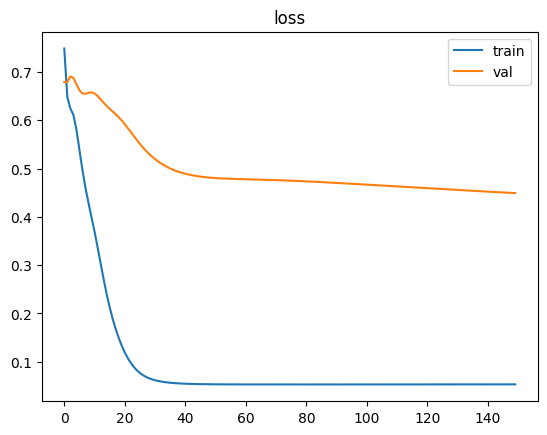

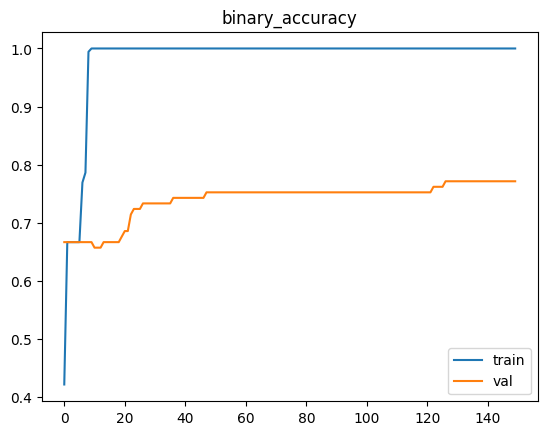

In [172]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [173]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.15152552859349686
train_binary_accuracy: 0.9383838393471458
loss: 0.6378382281823591
binary_accuracy: 0.760101014917547


In [ ]:
from deepmeg.interpreters import TimeCompNetInterpreter

interpreter = TimeCompNetInterpreter(model, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()

In [174]:
model = SPIRIT(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ],
            lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7238   |    binary_accuracy_train:  0.5613   |    loss_val:  0.6850   |    binary_accuracy_val:  0.6667
Epoch 1:  loss_train:  0.6701   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6843   |    binary_accuracy_val:  0.6667
Epoch 2:  loss_train:  0.6682   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6931   |    binary_accuracy_val:  0.6667
Epoch 3:  loss_train:  0.6783   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6896   |    binary_accuracy_val:  0.6667
Epoch 4:  loss_train:  0.6752   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6771   |    binary_accuracy_val:  0.6667
Epoch 5:  loss_train:  0.6618   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6648   |    binary_accuracy_val:  0.6667
Epoch 6:  loss_train:  0.6458   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6596   |    binary_accuracy_val:  0.6667
Epoch 7:  loss_train:  0.6345   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6627   | 

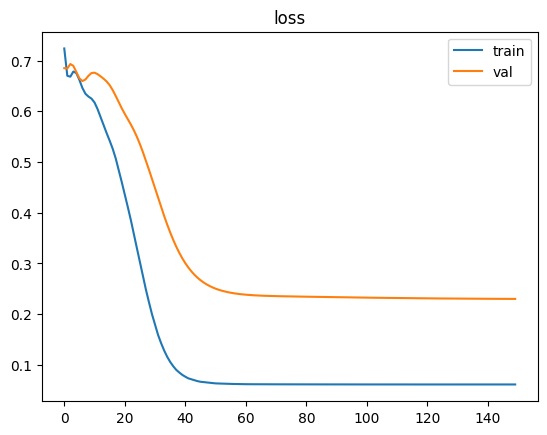

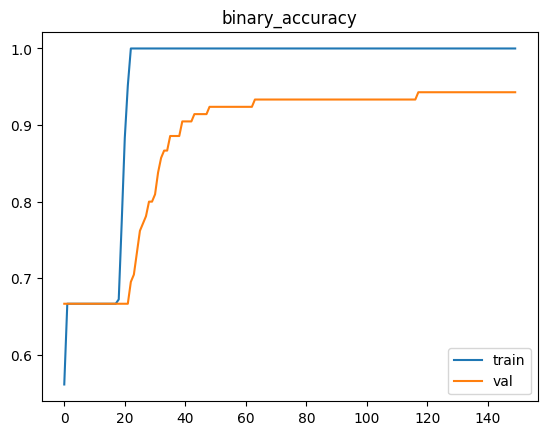

In [175]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [177]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.09639232131567868
train_binary_accuracy: 0.9878787886012684
loss: 0.2837245234034278
binary_accuracy: 0.9015151479027488


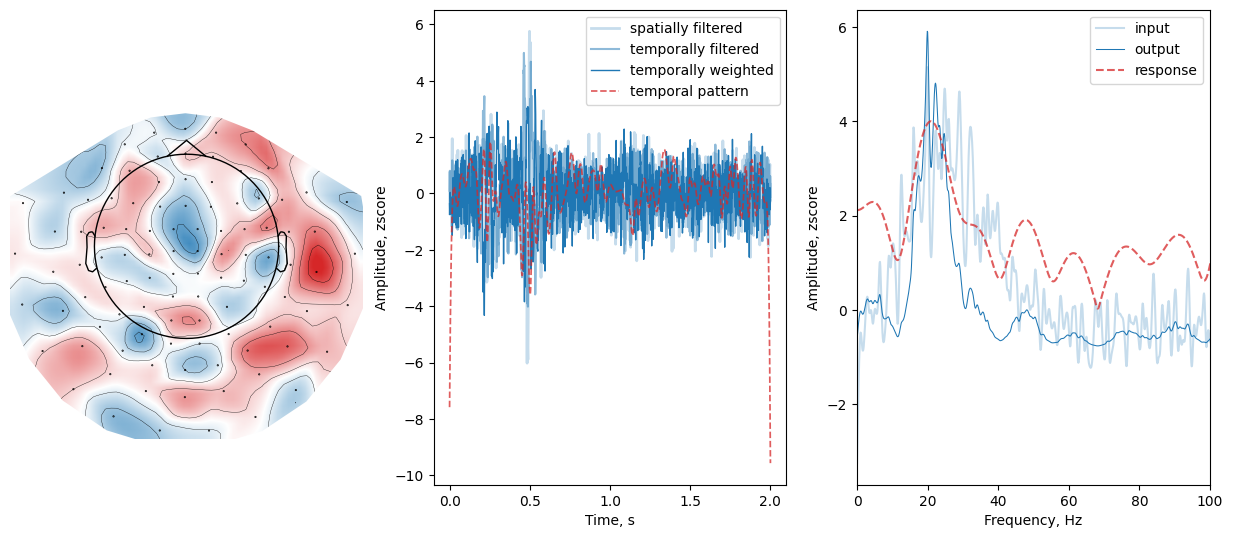

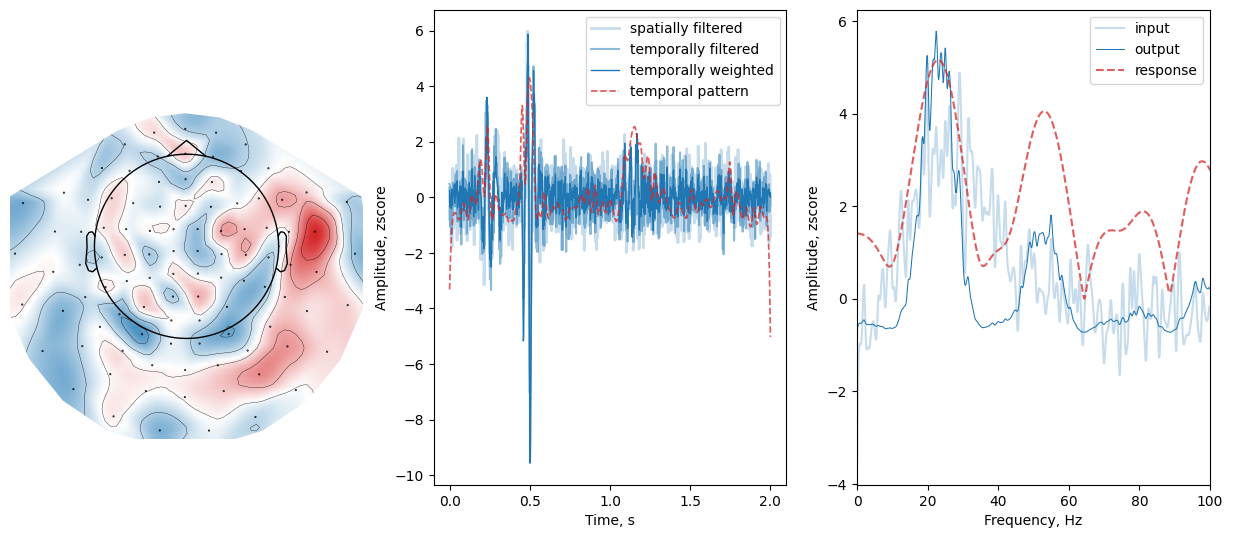

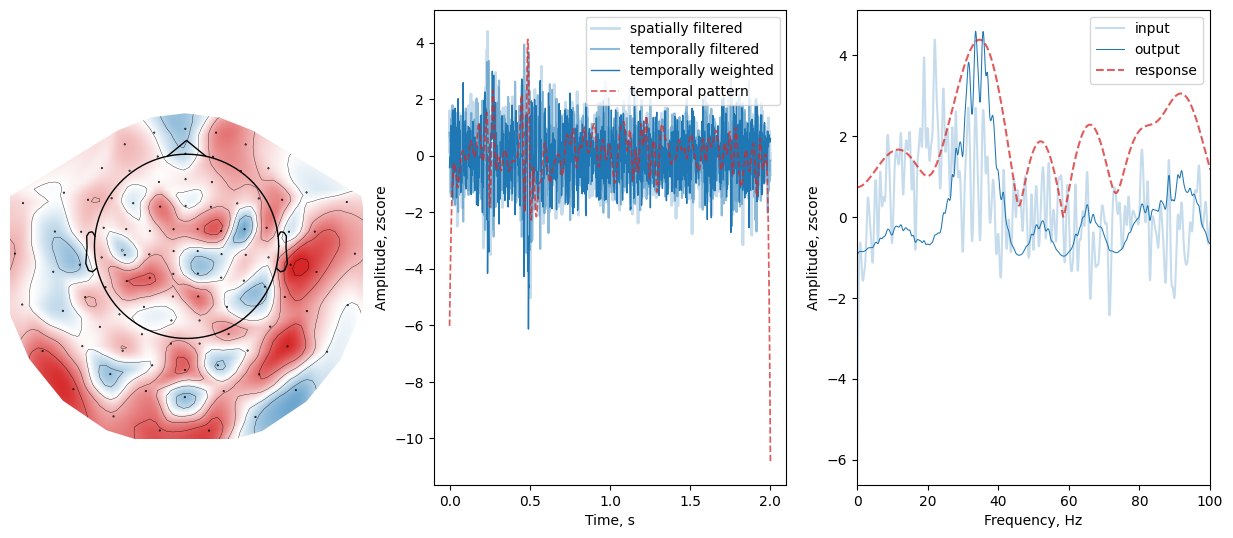

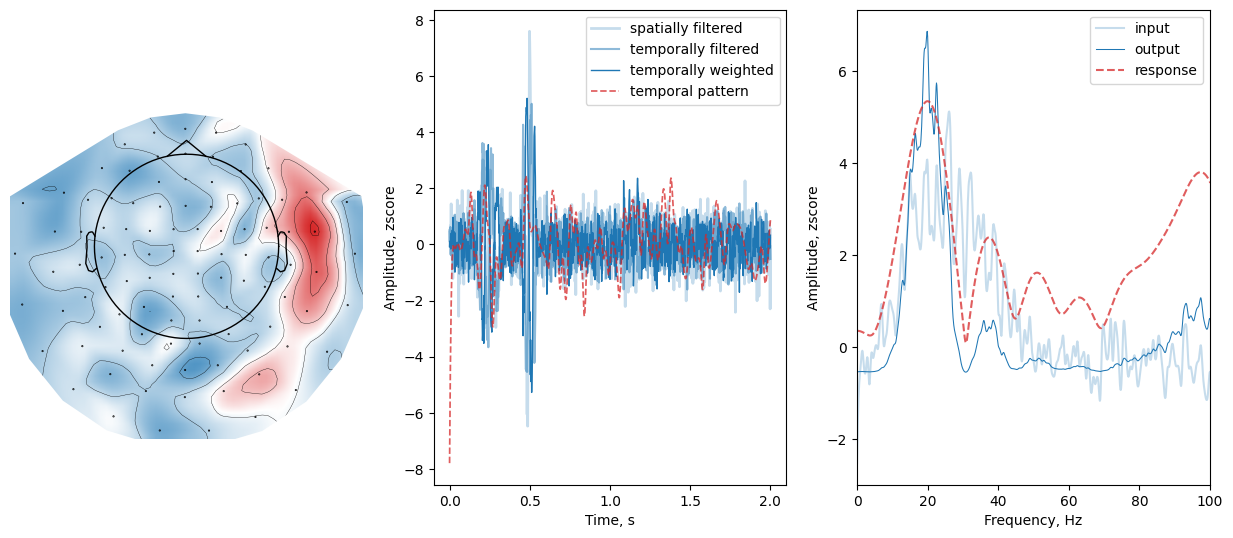

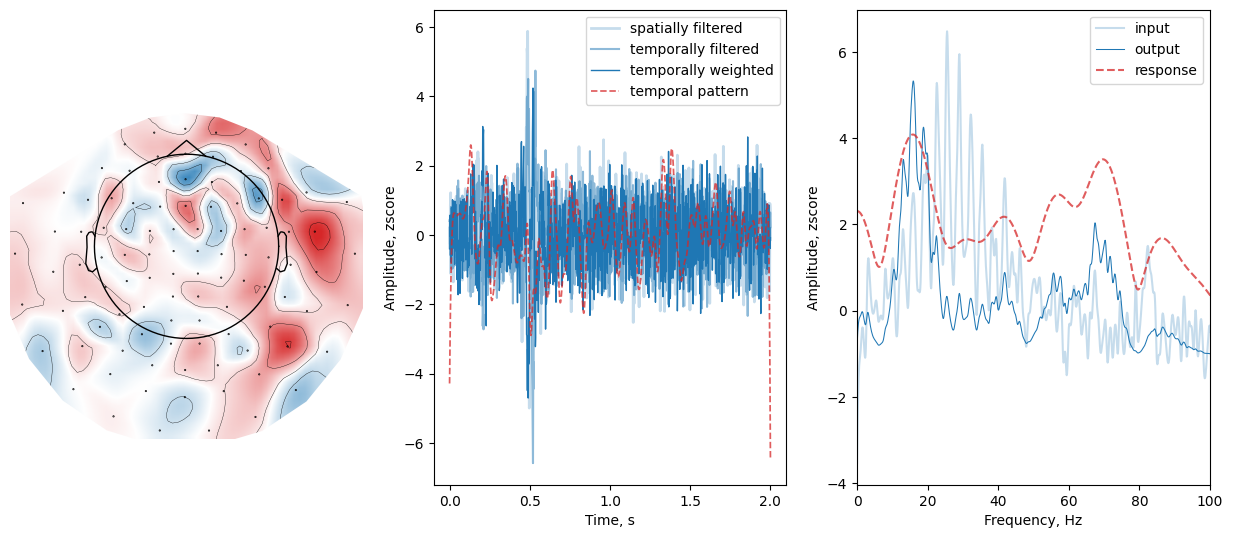

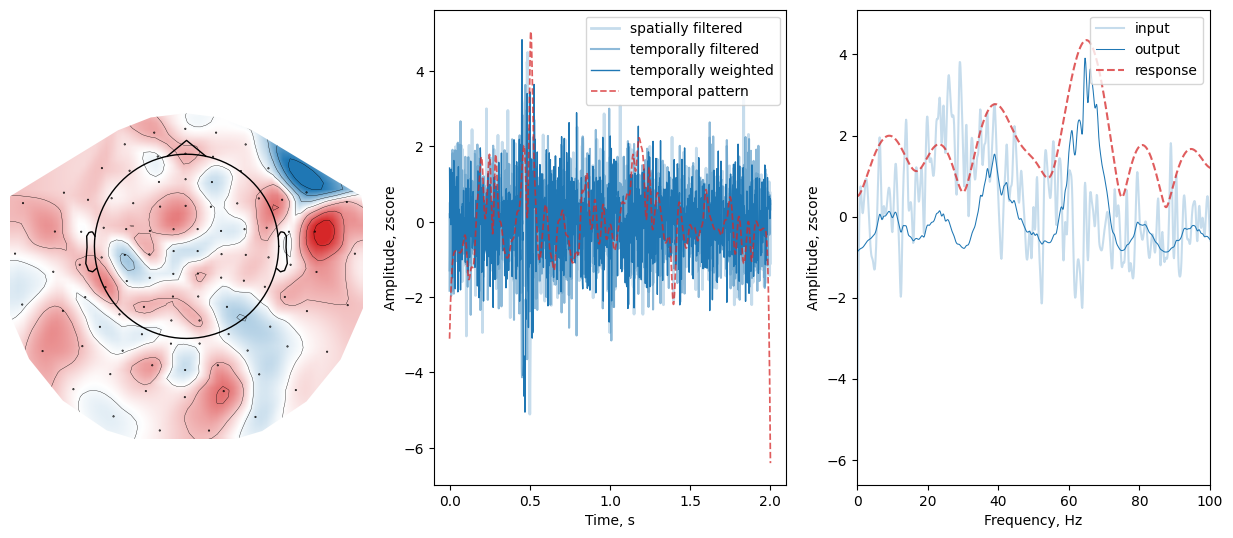

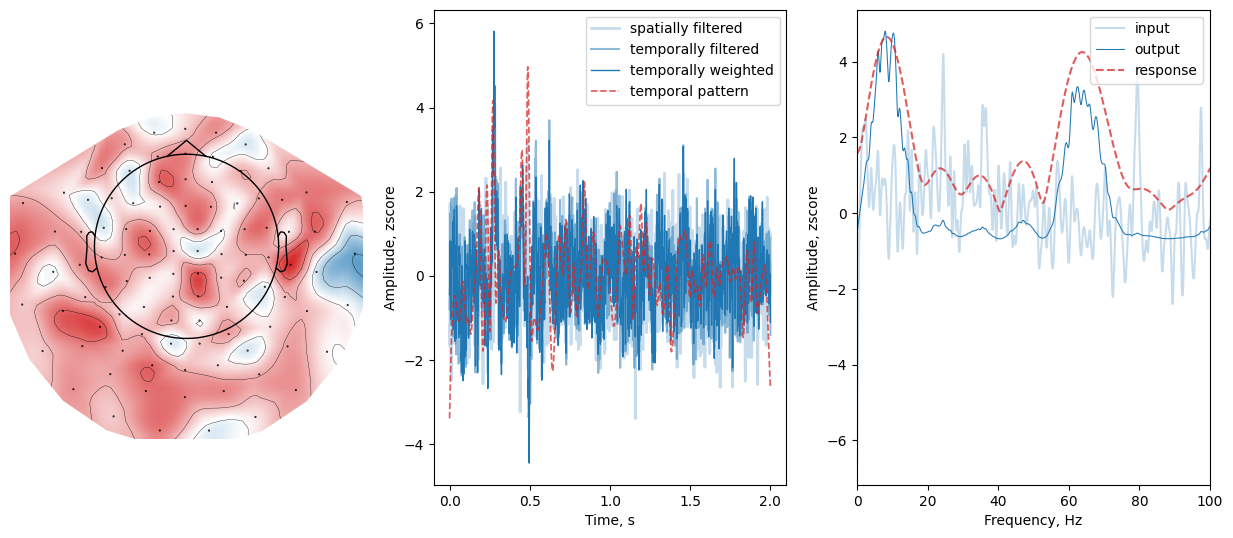

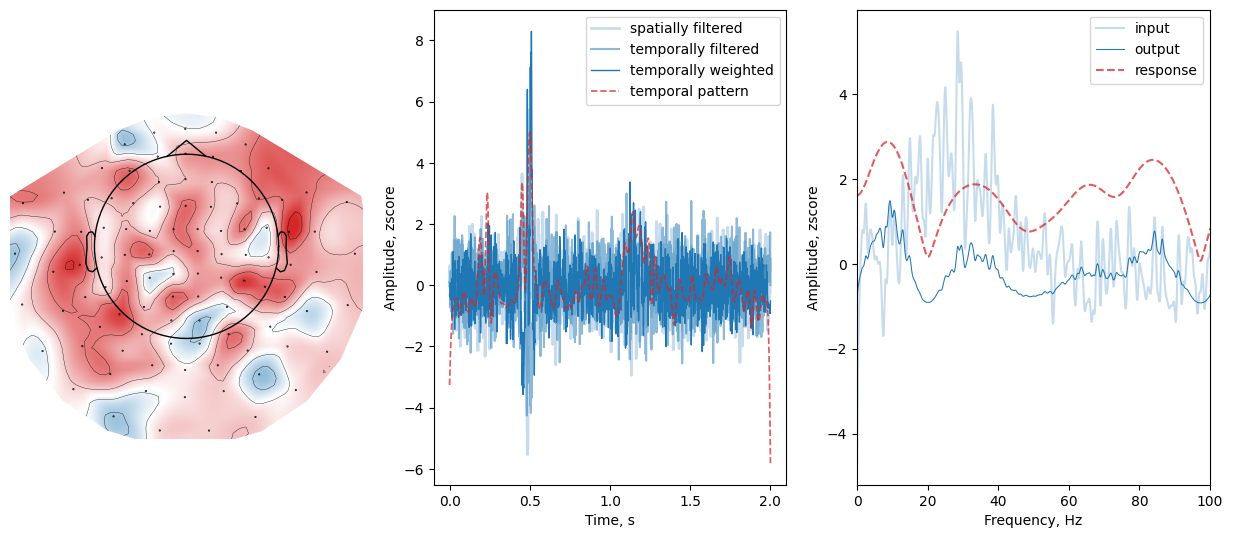

In [178]:
interpreter = SPIRITInterpreter(model, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()